 # [Module 1.7] AutoGluon 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 데이터 로딩
- 카테고리 피쳐의 레이블 인코딩
    - 훈련, 테스트 데이터 인코딩 (테스트 데이터의 인코딩시에 훈련에 없는 항목은 'Unknown' 으로 인코딩)
- AutoGluon 데이터 타입으로 변경
- AutoGluon 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

#### AutoGluon Tabular Prediction
- 오토글루온 Tabular 공식 페이지 입니다. 자세한 내용은 아래 링크를 참조 하세요.
    - https://autogluon.mxnet.io/stable/tutorials/tabular_prediction/index.html

## 데이터 세트 로딩
로컬에 저장된 파일을 로딩해서, 다시 한번 Shape(Row, column)을 확인하고 데이터를 확인 합니다.

In [1]:
import pandas as pd

In [2]:
%store -r no_auto_train_file
%store -r no_auto_test_file

In [3]:
train_pd = pd.read_csv(no_auto_train_file)
test_pd = pd.read_csv(no_auto_test_file)

In [4]:
print("auto_train_file: ", train_pd.shape)
print("auto_train_file: ", test_pd.shape)

auto_train_file:  (53740, 18)
auto_train_file:  (13436, 18)


In [5]:
from IPython.display import display as dp
dp(train_pd.head(2))
dp(test_pd.head(2))

,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,12030,taubate,SP,29.99,10.96,9000.0,fashion_shoes,13481,limeira,SP,1,4,10,SP_SP,taubate_limeira,12030_13481,2640.0
1,2,78075,cuiaba,MT,23.90,26.82,1500.0,furniture_decor,17051,bauru,SP,1,4,10,MT_SP,cuiaba_bauru,78075_17051,14625.0


,classes,customer_zip_code_prefix,customer_city,customer_state,price,freight_value,product_weight_g,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,order_weekday,order_day,order_month,customer_seller_state,customer_seller_city,customer_seller_zip_code_prefix,product_volume
0,3,89219,joinville,SC,105.00,23.89,1000.0,watches_gifts,21840,rio de janeiro,RJ,1,19,6,SC_RJ,joinville_rio de janeiro,89219_21840,7632.0
1,0,9950,diadema,SP,99.97,15.80,650.0,housewares,32677,betim,MG,1,19,6,SP_MG,diadema_betim,9950_32677,9600.0


In [6]:
from p_utils import convert_date_type

train_pd = convert_date_type(train_pd, col1='customer_zip_code_prefix')
test_pd = convert_date_type(test_pd, col1='customer_zip_code_prefix')
train_pd = convert_date_type(train_pd, col1='seller_zip_code_prefix')
test_pd = convert_date_type(test_pd, col1='seller_zip_code_prefix')

train_pd.info()

object
object
object
object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53740 entries, 0 to 53739
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   classes                          53740 non-null  int64  
 1   customer_zip_code_prefix         53740 non-null  object 
 2   customer_city                    53740 non-null  object 
 3   customer_state                   53740 non-null  object 
 4   price                            53740 non-null  float64
 5   freight_value                    53740 non-null  float64
 6   product_weight_g                 53740 non-null  float64
 7   product_category_name_english    53740 non-null  object 
 8   seller_zip_code_prefix           53740 non-null  object 
 9   seller_city                      53740 non-null  object 
 10  seller_state                     53740 non-null  object 
 11  order_weekday                    53740 non-null  int

## Category 레이블 Encoding

### Category 변수의 레이블 인코딩 실행

In [7]:
from p_utils import make_test_label_encoding
label_cols = ['customer_city','customer_state','customer_zip_code_prefix',
              'seller_zip_code_prefix','seller_city','seller_state',
              'customer_seller_state','customer_seller_city','customer_seller_zip_code_prefix',
              'product_category_name_english',
             ]
# label_cols = ['customer_city','customer_state']
# label_cols = ['customer_city']
train_pd, test_pd = make_test_label_encoding(train_pd, test_pd, label_cols)

Starting:  customer_city
new col name:  lb_customer_city
Starting:  customer_state
new col name:  lb_customer_state
Starting:  customer_zip_code_prefix
new col name:  lb_customer_zip_code_prefix
Starting:  seller_zip_code_prefix
new col name:  lb_seller_zip_code_prefix
Starting:  seller_city
new col name:  lb_seller_city
Starting:  seller_state
new col name:  lb_seller_state
Starting:  customer_seller_state
new col name:  lb_customer_seller_state
Starting:  customer_seller_city
new col name:  lb_customer_seller_city
Starting:  customer_seller_zip_code_prefix
new col name:  lb_customer_seller_zip_code_prefix
Starting:  product_category_name_english
new col name:  lb_product_category_name_english


### 필요 피쳐만 선택

In [8]:
from p_utils import filter_df

cols = ['classes','price', 'freight_value', 'product_weight_g',
       'product_volume',
       'lb_customer_state', 'lb_customer_city','lb_customer_zip_code_prefix',
       'lb_seller_zip_code_prefix', 'lb_seller_city','lb_seller_state',    
       'lb_customer_seller_state','lb_customer_seller_city','lb_customer_seller_zip_code_prefix' ,   
       'lb_product_category_name_english',
       ]

train_pd = filter_df(train_pd, cols)
test_pd = filter_df(test_pd, cols)


In [14]:
from autogluon.tabular import TabularPredictor as task
from autogluon.tabular import TabularDataset

## 오토글루온 데이터 타입으로 변경
로컬에 저장된 파일을 오토글로온의 Tabular 데이터 타입으로 로딩 합니다. 이후 랜덤 샘플링을 하고 데이터를 확인 합니다.
- 아래 데이타 샘플을 모두 하면 약 4:30 초 훈련 시간이 걸림

In [15]:
# train_data = task.Dataset(df = train_pd)

train_data = TabularDataset(train_pd)
# subsample_size = train_data.shape[0]
subsample_size = 500  # subsample subset of data for faster demo, try setting this to much larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
print(train_data.head(1))

     classes  price  freight_value  product_weight_g  product_volume  \
588        2  59.99           18.0             525.0          9280.0   

    lb_customer_state lb_customer_city lb_customer_zip_code_prefix  \
588                17             1560                        9699   

    lb_seller_zip_code_prefix lb_seller_city lb_seller_state  \
588                       169            388              20   

    lb_customer_seller_state lb_customer_seller_city  \
588                      204                   10810   

    lb_customer_seller_zip_code_prefix lb_product_category_name_english  
588                              43033                               66  


### 레이블 컬럼 지정
**레이블 컬럼을 지정하여, 오토글루온이 이 컬럼을 레이블로 인식하게 합니다.**

In [16]:
label_column = 'classes'
# print("Summary of class variable: \n", train_data[label_column].describe())

## 오토글루운으로 훈련
- 시간 제약을 2시간으로 합니다. 하지만 아래 훈련은 약 5분 소요 됩니다.
- 훈련 데이터 세트의 사이즈에 따라서 시간은 다양 합니다.
- 하지만 presets를 best_quality 으로 설정하면, 시간은 약 1시간 30분이 소요 됩니다. 하지만 이 경우에는 성능은 다소 올라갑니다. 다른 데이터 세트의 경우는 성능이 올라가는 정도가 다를 수 있습니다. 

In [18]:

%%time
save_path = 'adv_agModels-predictClass'  # specifies folder where to store trained models
presets = 'medium_quality_faster_train'


predictor = task(label=label_column, path = save_path).fit(train_data, presets=presets,
                                                   excluded_model_types=['KNN','GBM','NN','FASTAI','RF']
                                                   )



Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ...
AutoGluon will save models to "adv_agModels-predictClass/"
AutoGluon Version:  0.2.0
Train Data Rows:    500
Train Data Columns: 14
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [2, 3, 1, 0, 4]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
NumExpr defaulting to 2 threads.
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    2286.84 MB
	Train Data (Original)  Memory Usage: 0.32 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes

CPU times: user 12.1 s, sys: 586 ms, total: 12.7 s
Wall time: 10.5 s


## 테스트 데이터 로딩
- 테스트 데이터를 로딩하여 모델을 평가 합니다.
- 여기서는 y_test의 레이블만 가지고 있는 변수를 생성
- test_data_nolab는 레이블만 없는 피쳐만으로 구성된 데이터를 생성 합니다.

In [19]:
test_data = TabularDataset(test_pd)
y_test = test_data[label_column]  # values to predict
test_data_nolab = test_data.drop(labels=[label_column],axis=1)  # delete label column to prove we're not cheating
print(test_data_nolab.head(2))

    price  freight_value  product_weight_g  product_volume lb_customer_state  \
0  105.00          23.89            1000.0          7632.0                23   
1   99.97          15.80             650.0          9600.0                25   

  lb_customer_city lb_customer_zip_code_prefix lb_seller_zip_code_prefix  \
0             1372                       10728                       482   
1              784                       11737                       724   

  lb_seller_city lb_seller_state lb_customer_seller_state  \
0            373              14                      271   
1             56               6                      288   

  lb_customer_seller_city lb_customer_seller_zip_code_prefix  \
0                    9397                              51403   
1                    5468                              51403   

  lb_product_category_name_english  
0                               71  
1                               50  


## 모델 예측
- 생성된 모델을 통해서 추론(예측)을 합니다.
- 진실값 (y_test), 예측값(prediction)을 제공하여 accuracy, f1, precision, recall 를 계산 합니다.

In [20]:
# predictor = task.load(dir)  # unnecessary, just demonstrates how to load previously-trained predictor from file

prediction = predictor.predict(test_data_nolab)
print("Predictions:  ", prediction)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=prediction, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.3358886573384936
Evaluations on test data:
{
    "accuracy": 0.3358886573384936,
    "balanced_accuracy": 0.2748545756295234,
    "mcc": 0.10020829619369806
}


Predictions:   0        2
1        2
2        3
3        2
4        3
        ..
13431    2
13432    2
13433    4
13434    1
13435    0
Name: classes, Length: 13436, dtype: int64


예측 확률에 대한 predict_proba() 를 확인하기 위해서는 아래를 보세요
- API URL: https://auto.gluon.ai/api/autogluon.task.html#module-autogluon.tabular.tabular_prediction

## 리더 보드 생성
오토글루온에서 사용된 알고리즘의 성능 관련 지표를 확인 합니다. (예: score_test)

In [21]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,0.398854,0.33,0.043133,0.013830,5.687734,0.043133,0.013830,5.687734,1,True,1
1,ExtraTreesEntr,0.344820,0.27,0.334454,0.112472,0.766065,0.334454,0.112472,0.766065,1,True,3
2,ExtraTreesGini,0.338940,0.27,0.334653,0.113153,0.946318,0.334653,0.113153,0.946318,1,True,2
3,WeightedEnsemble_L2,0.335889,0.38,0.603507,0.139760,8.377902,0.005709,0.000624,0.167647,2,True,5
4,XGBoost,0.326362,0.37,0.220212,0.012834,1.756456,0.220212,0.012834,1.756456,1,True,4


## 모델 평가 및 Confusion 매트릭스
- SKLearn으로 accuracy, f1 score를 계산 합니다. 오토글루온의 수치와 동일한 결과가 나옵니다.
- Confusion 매트릭스 를 통해서 어느 레이블에서 잘 예측을 했는지를 확인 합니다.

In [22]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.34%
f1_score: 0.28%


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/pylab/config.py:79: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


[[ 344  893  340  101   27]
 [ 290 1131 1745  827  169]
 [ 114  550 2321 1247  303]
 [  50  185 1147  633  153]
 [  13   52  448  269   84]]


<Figure size 432x288 with 0 Axes>

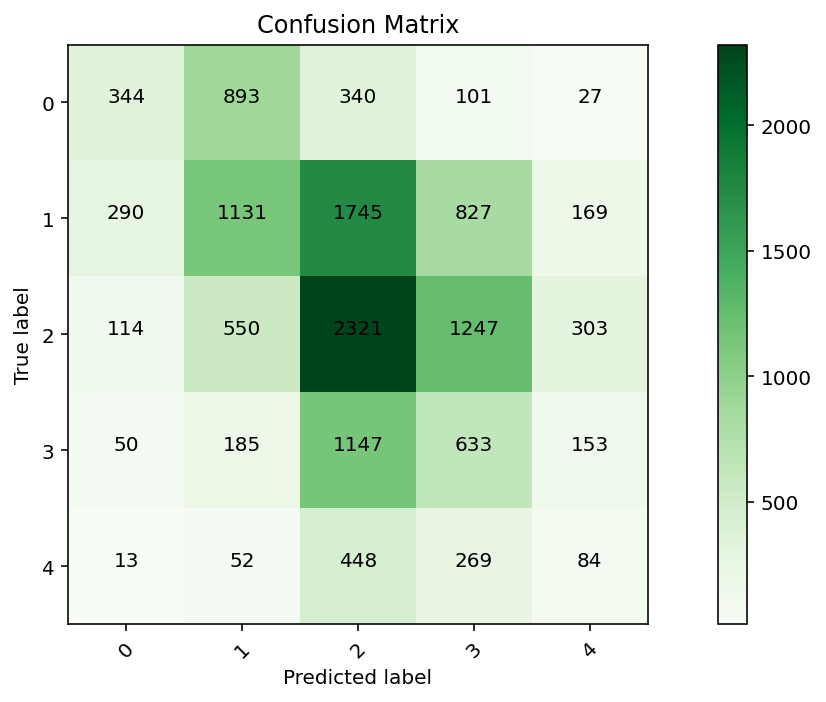

In [23]:
from p_utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance
- 피쳐의 중요도를 확인 합니다.

Computing feature importance via permutation shuffling for 14 features using 1000 rows with 3 shuffle sets...
	18.0s	= Expected runtime (6.0s per shuffle set)
	3.47s	= Actual runtime (Completed 3 of 3 shuffle sets)


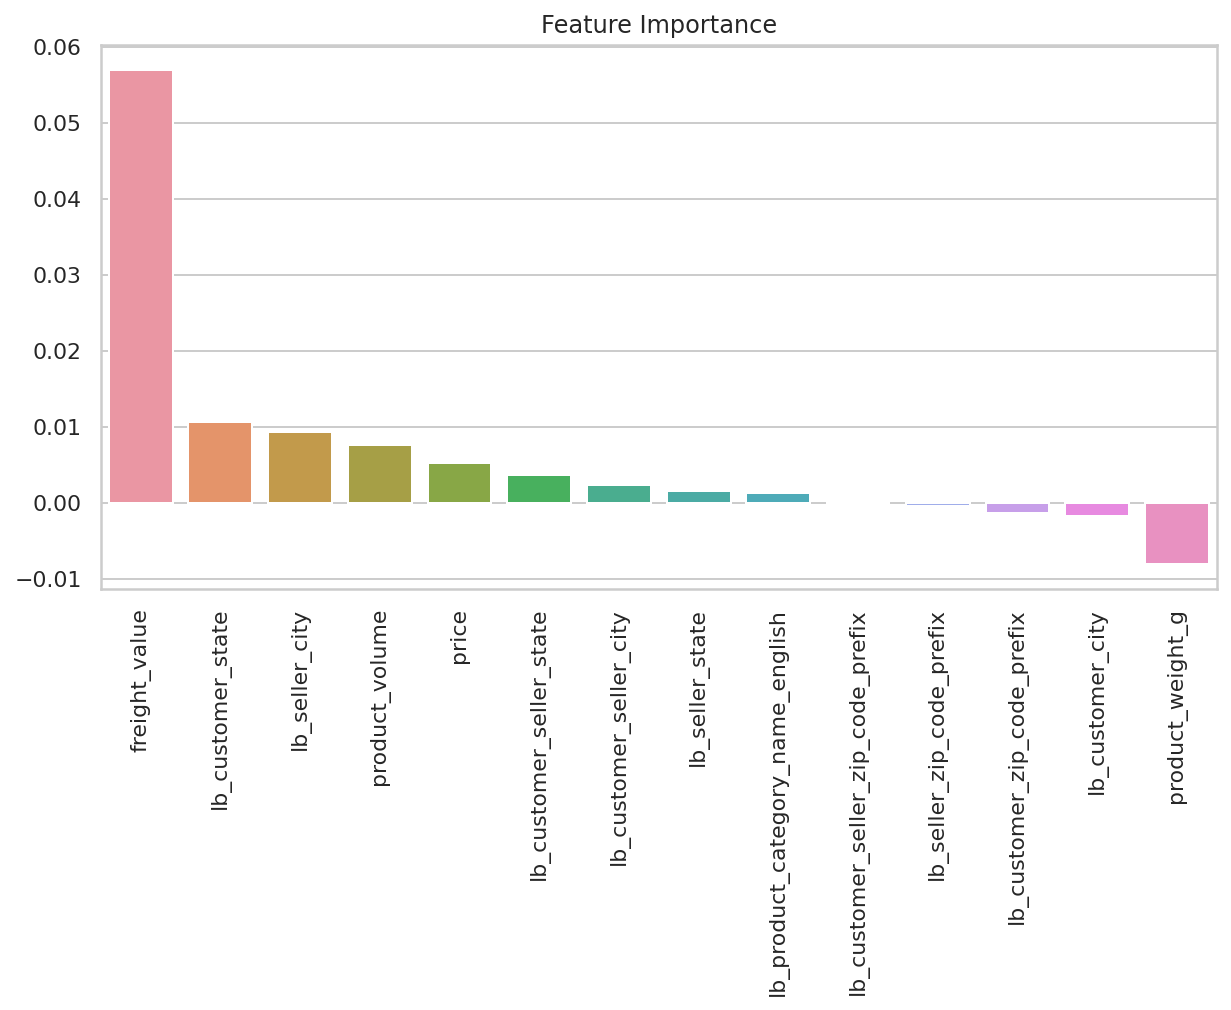

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fea_importance = predictor.feature_importance(test_data)

fea_imp = fea_importance['importance']

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=fea_imp.index, y = fea_imp.values)
# plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()